In [228]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import tensorflow_probability as tfp 
import scipy as sp
import seaborn as sns 

import sys 

sys.path.append('/Users/alinmorariu/Documents/Github/ContinuousTimeIndividualLevelEpidemicModels')

In [229]:
sns.set_theme()

In [230]:
DTYPE = tf.float32

In [231]:
population_size = 4 # 3 infected, 1 occult 

# Characteristic data simulation

In [232]:
ind_id = ['A', 'B', 'C', 'D']

In [233]:
np.random.seed(20230720)
location_data = np.random.uniform(low = 0.0, high = 10.0, size = (population_size,2))

<AxesSubplot:xlabel='Long', ylabel='Lat'>

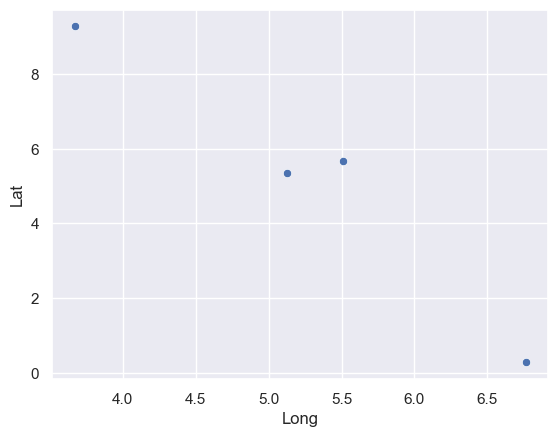

In [234]:
sns.scatterplot(data=pd.DataFrame(
    location_data, columns=('Long', 'Lat')), x='Long', y='Lat')

In [235]:
farm_size = [30, 7, 70, 20]

In [236]:
raw_data = {'ind_id': ind_id,
 'long': location_data[:, 0],
 'lat': location_data[:, 1],
 'farm_size': farm_size}

In [237]:
np.column_stack((location_data[:, 0], location_data[:, 1], farm_size))

array([[ 6.7622786 ,  0.27765238, 30.        ],
       [ 3.67218619,  9.27634228,  7.        ],
       [ 5.51130133,  5.66629101, 70.        ],
       [ 5.12430292,  5.36310558, 20.        ]])

In [238]:
characteristic_data = tf.convert_to_tensor(np.column_stack(
    (location_data[:, 0], location_data[:, 1], farm_size)), dtype=DTYPE, name='long-lat-size')

In [239]:
characteristic_data 

<tf.Tensor: shape=(4, 3), dtype=float32, numpy=
array([[ 6.7622786 ,  0.27765238, 30.        ],
       [ 3.6721861 ,  9.276342  ,  7.        ],
       [ 5.5113015 ,  5.666291  , 70.        ],
       [ 5.124303  ,  5.363106  , 20.        ]], dtype=float32)>

# Stochastic process

In [240]:
# Define variables to govern epidemic
sir_graph = np.array([[-1, 0],
                      [1, -1],
                      [0, 1]], dtype=np.float32)


initial_state = np.array([[2],
                          [1],
                          [1]], dtype=np.float32)

In [241]:
THEORETICAL_VALUES = tf.constant((0.8, 1.2, 3.14, 2), dtype=DTYPE)
THEORETICAL_VALUES_DICT = {
    'reg': THEORETICAL_VALUES[0:2], 'spatial': THEORETICAL_VALUES[2], 'removal': THEORETICAL_VALUES[3]}

In [242]:
THEORETICAL_VALUES_DICT

{'reg': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.8, 1.2], dtype=float32)>,
 'spatial': <tf.Tensor: shape=(), dtype=float32, numpy=3.14>,
 'removal': <tf.Tensor: shape=(), dtype=float32, numpy=2.0>}

In [243]:
###########
# Hazard fn
###########

# 1. Compute spatial component
def pairwise_distance(location_data):
    """Compute pairwise distance matrix between farms

    Args:
        farm_locations_data (DataFrame): Lat-Long coordinates of farms

    Returns:
        tensor: tensor of Euclidean distances between entities
                Dim = len(farm_location_data)
    """
    return tf.convert_to_tensor(
        sp.spatial.distance.squareform(
            sp.spatial.distance.pdist(location_data)
        ),
        dtype=DTYPE
    )


def generate_spatial_kernel(pairwise_distance_tensor):
    farm_distance_matrix = tf.convert_to_tensor(
        pairwise_distance_tensor, DTYPE)

    def square_exponential_kernel(parameters):
        parameters = tf.convert_to_tensor(parameters, DTYPE)
        partial_step = tf.math.multiply(pairwise_distance_tensor, 1/parameters)
        return tf.math.exp(-tf.math.square(partial_step))

    return square_exponential_kernel

# 2. Compute regression component


def generate_regression_pressure(characteristic_data=None):
    """_summary_

    Args:
        farm_characteristics_data (_type_, optional): Factor variables for each farm unit. Defaults to None.

    Returns:
        tensor: exp(alpha + beta * data)
    """
    characteristic_data = tf.convert_to_tensor(characteristic_data, DTYPE)

    def compute_regression(parameters):
        parameters = tf.convert_to_tensor(parameters, DTYPE)
        # note: char_data is a column vector so this needs to change for general case
        one_padded_data = tf.stack([np.full(np.shape(characteristic_data), 1.0),
                                    characteristic_data], axis=-1)
        regression = tf.matmul(one_padded_data, tf.expand_dims(parameters,-1))
        expontiated_regression = tf.math.exp(-regression)
        return expontiated_regression

    return compute_regression

# 3. Combine for overall hazard function


def generate_pairwise_hazard_fn(pairwise_distance_tensor, characteristic_data):
    """_summary_

    Args:
        farm_characteristics_data (_type_): features of farms, including a 1s column for regression
        farm_locations_data (_type_): Northing-Easting coordinates of farms

    Returns:
        fn: fn which outputs a tensor of pairwise hazard rates
    """
    spatial_kernel = generate_spatial_kernel(pairwise_distance_tensor)
    regression_kernel = generate_regression_pressure(characteristic_data)

    def compute_hazard(parameters_dict):

        # spatial component - already exponentiated!
        spatial = spatial_kernel(parameters_dict.get("spatial"))

        # regression component - already exponentiated!
        regression = regression_kernel(parameters_dict.get("reg"))
        return tf.math.multiply(spatial,
                                regression
                                )

    return compute_hazard

In [244]:
# example usage 
generate_pairwise_hazard_fn(
    pairwise_distance_tensor=pairwise_distance(location_data),
    characteristic_data=tf.stack(characteristic_data[:, -1]))(THEORETICAL_VALUES_DICT) 

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[1.04222957e-16, 1.07281715e-20, 4.67728616e-18, 5.76269436e-18],
       [1.04004645e-08, 1.01039324e-04, 1.91184536e-05, 1.72617820e-05],
       [0.00000000e+00, 2.81053472e-38, 1.48534252e-37, 1.44937488e-37],
       [9.37906111e-13, 2.89795987e-12, 1.65520306e-11, 1.69627853e-11]],
      dtype=float32)>

In [245]:
############
# Removal fn
############

def generate_removal_fn(infection_time, removal_time):
    time_diff = removal_time - infection_time

    def removal_fn(parameters):
        return tfp.distributions.Exponential(rate=parameters).prob(time_diff)

The hazard functions and removal function correspond to the $S \rightarrow I$ and $I \rightarrow R$ transitions of the $SIR$ model. They can be combined in order to evaluate the likelihood of the epidemic. Implementation requires the raw data (called the characteristic data in the code above) and timestamps for the epidemic events. We create a closure over the model parameters (target of the MCMC scheme) and evaluate the likelihood at proposed parameter values. Several additional functions are required in order to compute the like likelihood. The hazard function quantifies pairwise infectious pressure but does not factor in the directionality of that pressure since it is missing information about the ordering of events (i.e. at a given time, a susceptible individual does not exert infectious pressure on another susceptible individual, but an infectious individual does exert infectious pressure on susceptibles). Direction of infection is determined by the computation of a "who acquired infection from who" (called the WAIFW matrix). The WAIFW matrix encodes whether or not individual $j$ is exerts infectious pressure on individual $i$ by checking for overlap of individual $j$'s infectious period with individual $i$'s susceptible period. 

In [268]:
def generate_waifw(infection_times, removal_times):
    """
    Compute a WAIFW (who acquired infection from who) matrix 
    given tensors of infection and removal times. 

    Args:
        infection_times (datetime): array of infection times 
        removal_times (datetime): array of removal times 

    Returns:
        tensor: len(infection_times) x len(infection_times) tensor of 1s and 0s
    """

    infection_times = tf.convert_to_tensor(infection_times, dtype=DTYPE)
    removal_times = tf.convert_to_tensor(removal_times, dtype=DTYPE)

    # use the expand_dim to do the [I,:] trick
    waifw = tf.math.logical_and(
        # compare infections to infections: I_i <= I_j
        infection_times[tf.newaxis, :] < infection_times[:, tf.newaxis],
        # compare infections to removals: I_j <= R_i
        infection_times[:, tf.newaxis] < removal_times[tf.newaxis, :]
    )
    return tf.cast(waifw,
                   dtype=DTYPE)

With the direction of infectious pressure being determined, we now turn to the exposure matrix which provides the duration that infectious pressure is exerted from one individual to another. 

In [269]:
def generate_exposure(infection_times, removal_times):
    """
    Compute exposure matrix given two tensors of infections and removal times

    Args:
        infection_times (datetime): array of infection times 
        removal_times (datetime): array of removal times 

    Returns:
        tensor: len(infection_times) x len(infection_times) tensor of exposure
        durations 
    """
    infection_times = tf.convert_to_tensor(infection_times, dtype=DTYPE)
    removal_times = tf.convert_to_tensor(removal_times, dtype=DTYPE)

    return (
        tf.math.minimum(infection_times[:, tf.newaxis],
                        removal_times[tf.newaxis, :]) -
        tf.math.minimum(infection_times[:, tf.newaxis],
                        infection_times[tf.newaxis, :])
    )

In [250]:
def identify_initial_infective(infection_times):
    infection_times = tf.convert_to_tensor(infection_times, dtype=DTYPE)
    return tf.argmin(infection_times)

## Create fake dates

In [274]:
# Create fake dates 
epidemic_timestamps = {'ind_id': indivudal_id,
 'infection_time': np.array([0, 5.4, 3.7835, np.inf]),
'removal_time': np.array([6.111, 8.4954, 10.03313, np.inf])}

In [281]:
def generate_infectious_duration(infection_times, removal_times):
    infection_times = tf.convert_to_tensor(infection_times, dtype=DTYPE)
    removal_times = tf.convert_to_tensor(removal_times, dtype=DTYPE)
    return tf.math.subtract(x=removal_times,
                            y=infection_times)

In [282]:
# example
generate_infectious_duration(infection_times=epidemic_timestamps.get('infection_time'),
                 removal_times=epidemic_timestamps.get('removal_time'))

<tf.Tensor: shape=(4,), dtype=float32, numpy=array([6.111    , 3.0954003, 6.24963  ,       nan], dtype=float32)>

In [271]:
generate_exposure(infection_times=epidemic_timestamps.get('infection_time'),
                 removal_times=epidemic_timestamps.get('removal_time'))

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.       , 0.       , 0.       , 0.       ],
       [5.4      , 0.       , 1.6165001, 0.       ],
       [3.7835   , 0.       , 0.       , 0.       ],
       [6.111    , 3.0954003, 6.24963  ,       nan]], dtype=float32)>

In [272]:
generate_waifw(infection_times=epidemic_timestamps.get('infection_time'),
                 removal_times=epidemic_timestamps.get('removal_time'))

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0., 0., 0., 0.],
       [1., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)>

In [273]:
tf.matmul(a = generate_waifw(infection_times=epidemic_timestamps.get('infection_time'),
                 removal_times=epidemic_timestamps.get('removal_time')),
         b = generate_exposure(infection_times=epidemic_timestamps.get('infection_time'),
                 removal_times=epidemic_timestamps.get('removal_time')))

<tf.Tensor: shape=(4, 4), dtype=float32, numpy=
array([[0.    , 0.    , 0.    ,    nan],
       [3.7835, 0.    , 0.    ,    nan],
       [0.    , 0.    , 0.    ,    nan],
       [0.    , 0.    , 0.    ,    nan]], dtype=float32)>